In [1]:
import os
import csv
from collections import deque
import itertools
import time

import librosa

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Preprocessing
from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import f_classif

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

#Keras
import keras
from keras import models
from keras import layers
from keras.callbacks import Callback

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:518: F

In [2]:
#trainpath = '../data/kaggle-train-small/audio/'
trainpath = '../data/kaggle-train/audio/'
testpath = '../data/kaggle-test/audio/'

In [3]:
df_train = pd.read_pickle('./df_train.pkl')
df_train.head(20)

,filename,audiotype,instrument,chroma_stft_mean,chroma_stft_std,chroma_stft_max,chroma_stft_min,rmse_mean,rmse_std,rmse_max,...,mfcc_max17,mfcc_min17,mfcc_mean18,mfcc_std18,mfcc_max18,mfcc_min18,mfcc_mean19,mfcc_std19,mfcc_max19,mfcc_min19
0,keyboard_acoustic_010-064-050.wav,acoustic,keyboard,0.141385,0.289322,1.0,0.000000,0.061293,0.088629,0.366677,...,5.969509,-22.231743,3.564694,5.718117,12.494633,-10.551493,15.429117,7.454765,23.296577,0.000000
1,organ_electronic_048-084-127.wav,electronic,organ,0.153087,0.302638,1.0,0.000000,0.269546,0.152640,0.394531,...,0.000000,-23.805824,-11.306641,6.808135,0.000000,-23.264307,32.281609,18.238966,50.054951,0.000000
2,bass_synthetic_038-093-050.wav,synthetic,bass,0.187979,0.264302,1.0,0.000000,0.008968,0.027033,0.164048,...,2.266337,-23.719299,26.104923,15.218951,63.592525,0.000000,-13.752032,9.753820,1.451964,-50.337307
3,brass_acoustic_014-067-100.wav,acoustic,brass,0.228951,0.305377,1.0,0.000000,0.082316,0.048830,0.153490,...,51.589931,0.000000,42.621082,18.076965,61.070320,0.000000,18.158424,7.996955,29.988873,0.000000
4,bass_synthetic_123-070-075.wav,synthetic,bass,0.031193,0.148407,1.0,0.000000,0.013941,0.069042,0.516822,...,11.600046,-9.202660,0.019563,1.103113,8.654598,-8.673664,-0.736997,2.378023,1.830241,-13.317797
5,organ_electronic_065-061-050.wav,electronic,organ,0.116215,0.269425,1.0,0.000000,0.320845,0.201841,0.609368,...,0.000000,-22.542011,-10.947213,7.071216,0.000000,-25.852118,1.169024,3.583707,10.784775,-7.705932
6,guitar_acoustic_011-079-025.wav,acoustic,guitar,0.100189,0.251751,1.0,0.000000,0.009332,0.029059,0.210820,...,16.500767,-7.907526,12.453623,15.721991,55.157803,0.000000,4.995918,8.226757,30.507921,-0.023043
7,string_acoustic_010-040-127.wav,acoustic,string,0.220066,0.308069,1.0,0.000000,0.015233,0.044543,0.216359,...,8.253461,-15.325937,-1.397056,2.802639,9.433762,-13.979939,-1.792941,3.074017,8.232322,-16.778818
8,keyboard_electronic_004-074-025.wav,electronic,keyboard,0.050198,0.193557,1.0,0.000000,0.029618,0.090987,0.536846,...,0.000000,-31.314651,-5.752944,8.435960,0.000000,-27.361671,-3.430038,5.121261,1.771984,-16.050438
9,mallet_acoustic_075-084-025.wav,acoustic,mallet,0.346899,0.325698,1.0,0.000004,0.023630,0.052565,0.308262,...,11.093233,-14.221691,0.980078,2.564556,7.528526,-3.605413,2.709939,6.365163,24.339619,-5.514820


In [4]:
traindata = df_train[[c for c in df_train.columns if c not in ['filename', 'audiotype']]]
traindata.shape

# normalizing
scaler = StandardScaler()
#scaler = RobustScaler()
X = scaler.fit_transform(np.array(traindata.iloc[:,1:], dtype = float))

In [5]:
# defining target
encoder = LabelEncoder()
y = encoder.fit_transform(df_train['instrument'])
print(y.shape)
print(y[0:5])

(269776,)
[4 6 0 1 0]


In [6]:
# spliting of dataset into train and test dataset
#https://imbalanced-learn.readthedocs.io/en/stable/api.html#module-imblearn.under_sampling
#https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks
from imblearn.under_sampling import CondensedNearestNeighbour

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

smote = SMOTE(kind='regular', n_jobs=-1)
Xbal, ybal = smote.fit_sample(X, y)

#rus = RandomUnderSampler(n_jobs=-1)
#Xbal, ybal = rus.fit_sample(X, y)

#tl = TomekLinks(return_indices=True, ratio='majority', n_jobs=-1)
#Xbal, ybal, id_tl = tl.fit_sample(X, y)

#cnn = CondensedNearestNeighbour(n_jobs=-1)
#Xbal, ybal = cnn.fit_resample(X, y)

skf = StratifiedKFold(n_splits=2)
#train_index, test_index = next(skf.split(X, y))
train_index, test_index = next(skf.split(Xbal, ybal))

print(X.shape)
print(y.shape)
print(Xbal.shape)
print(ybal.shape)
print(Xbal[train_index].shape)
print(ybal[train_index].shape)
print(Xbal[test_index].shape)
print(ybal[test_index].shape)

(269776, 104)
(269776,)
(652740, 104)
(652740,)
(326370, 104)
(326370,)
(326370, 104)
(326370,)


In [7]:
np.save('./Xbal', Xbal)
np.save('./ybal', Xbal)

In [8]:
#https://towardsdatascience.com/multi-class-metrics-made-simple-part-ii-the-f1-score-ebe8b2c2ca1

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    plt.imshow(cm, interpolation='nearest', cmap=cmap, aspect='auto')
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def clf_eval(y_pred, y_true, classes=encoder.inverse_transform(range(10))):
    clf_matrix = confusion_matrix(y_true, y_pred)
    print('Classification Report')
    print(classification_report(y_true, y_pred, target_names=classes))
    #print('ROC Score: {}'.format(roc_auc_score(y_true, y_pred)))
    print('Accuracy Score: {}'.format(accuracy_score(y_true, y_pred)))
    #print('Average Precision Score: {}'.format(average_precision_score(y_true, y_pred)))
    print('f1 Score: {}'.format(f1_score(y_true, y_pred, average='micro')))
    plot_confusion_matrix(clf_matrix, classes=classes)
    return #roc_auc_score(y_true, y_pred)

#https://medium.com/@thongonary/how-to-compute-f1-score-for-each-epoch-in-keras-a1acd17715a2

class Metrics(Callback):
    
    def on_train_begin(self, logs={}):
        self.val_f1s = []
        self.val_recalls = []
        self.val_precisions = []
        self.aucs = []
        self.losses = []

    def on_train_end(self, logs={}):
        return

    def on_epoch_begin(self, epoch, logs={}):
        return
        
    def on_epoch_end(self, epoch, logs={}):
        val_predict = np.argmax(np.asarray(self.model.predict(self.validation_data[0])), axis=1).round()
        val_targ = self.validation_data[1]
        _val_f1 = f1_score(val_targ, val_predict, average='micro')
        _val_recall = recall_score(val_targ, val_predict, average='micro')
        _val_precision = precision_score(val_targ, val_predict, average='micro')
        self.val_f1s.append(_val_f1)
        self.val_recalls.append(_val_recall)
        self.val_precisions.append(_val_precision)
        self.losses.append(logs.get('loss'))
        y_pred = self.model.predict(self.validation_data[0])
        #self.aucs.append(roc_auc_score(self.validation_data[1], y_pred))
        print('— val_f1: {} — val_precision: {} — val_recall {}'.format(_val_f1, _val_precision, _val_recall))
        return
    
    def on_batch_begin(self, batch, logs={}):
        return

    def on_batch_end(self, batch, logs={}):
        return
 
metrics = Metrics()

#### Random Forests

Classification Report
              precision    recall  f1-score   support

        bass       0.98      0.94      0.96     32637
       brass       1.00      1.00      1.00     32637
       flute       0.99      1.00      1.00     32637
      guitar       0.97      0.97      0.97     32637
    keyboard       0.94      0.94      0.94     32637
      mallet       0.96      0.99      0.97     32637
       organ       0.98      0.99      0.99     32637
        reed       1.00      0.99      1.00     32637
      string       0.99      1.00      1.00     32637
       vocal       1.00      1.00      1.00     32637

    accuracy                           0.98    326370
   macro avg       0.98      0.98      0.98    326370
weighted avg       0.98      0.98      0.98    326370

Accuracy Score: 0.9806416030885192
f1 Score: 0.9806416030885192
Confusion matrix, without normalization
[[30643    13    33   406   929   363   161    22    41    26]
 [    0 32611     7     1     1     0     3     3   

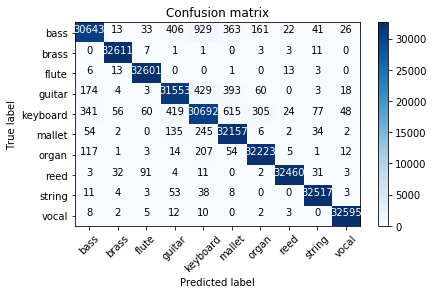

In [12]:
from sklearn.ensemble import RandomForestClassifier

clf_rf = RandomForestClassifier(n_estimators=300, 
                                criterion='gini', 
                                max_depth=None, 
                                min_samples_split=10,
                                min_samples_leaf=10, 
                                min_weight_fraction_leaf=0.0, 
                                max_features='auto', 
                                max_leaf_nodes=None, 
                                bootstrap=True, 
                                oob_score=False, 
                                n_jobs=-1, 
                                random_state=0, 
                                verbose=1, 
                                warm_start=False, 
                                class_weight='balanced').fit(Xbal[train_index], ybal[train_index])



yhat = clf_rf.predict(Xbal[test_index])
clf_eval(yhat, ybal[test_index])

#### XGBoost classifier

In [ ]:
import xgboost

clf_xgb = xgboost.sklearn.XGBClassifier(base_score=0.5,
                                        learning_rate=0.1,
                                        n_estimators=250,
                                        max_delta_step=0,
                                        max_depth=2,
                                        min_child_weight=1,
                                        missing=None,
                                        gamma=0.1,
                                        subsample=1,
                                        colsample_bylevel=1,
                                        colsample_bytree=1,
                                        objective= 'binary:logitraw',
                                        #objective='multi:softprob',
                                        reg_alpha=0, 
                                        reg_lambda=1,
                                        nthread=-1,
                                        scale_pos_weight=1,
                                        seed=0,
                                        silent=False,
                                        random_state=0).fit(Xbal[train_index], ybal[train_index])

yhat = clf_xgb.predict(Xbal[test_index])
clf_eval(yhat, ybal[test_index])

#### Regularized Greedy Forest

In [ ]:
from rgf.sklearn import RGFClassifier, FastRGFClassifier

clf_rgf = RGFClassifier(max_leaf=240,
                        algorithm="RGF_Sib",
                        test_interval=100,
                        verbose=False,).fit(Xbal[train_index], ybal[train_index])

yhat = clf_rgf.predict(Xbal[test_index])
clf_eval(yhat, ybal[test_index])

#### Keras and Tensor Flow

Train on 326370 samples, validate on 326370 samples
Epoch 1/30
326370/326370 [==============================] - 10s 31us/step - loss: 0.5754 - acc: 0.7929 - val_loss: 0.2806 - val_acc: 0.9014
— val_f1: 0.9014462113552103 — val_precision: 0.9014462113552103 — val_recall 0.9014462113552103
Epoch 2/30
326370/326370 [==============================] - 10s 30us/step - loss: 0.3026 - acc: 0.8907 - val_loss: 0.1828 - val_acc: 0.9368
— val_f1: 0.9368140454085854 — val_precision: 0.9368140454085854 — val_recall 0.9368140454085854
Epoch 3/30
326370/326370 [==============================] - 10s 31us/step - loss: 0.2324 - acc: 0.9162 - val_loss: 0.1487 - val_acc: 0.9489
— val_f1: 0.9488586573520851 — val_precision: 0.9488586573520851 — val_recall 0.9488586573520851
Epoch 4/30
326370/326370 [==============================] - 10s 29us/step - loss: 0.1976 - acc: 0.9289 - val_loss: 0.1197 - val_acc: 0.9598
— val_f1: 0.9598431228360449 — val_precision: 0.959843122836045 — val_recall 0.959843122836045
Ep

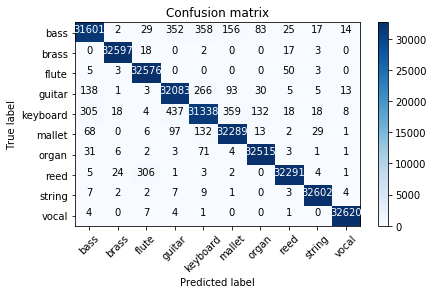

In [21]:
# creating a model
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(Xbal[train_index].shape[1],)))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
              
history = model.fit(Xbal[train_index],
                    ybal[train_index],
                    validation_data=(Xbal[test_index],ybal[test_index]),
                    #validation_split=0.2,
                    epochs=30,
                    batch_size=128,
                    callbacks=[metrics]
                   )
                    
# calculate accuracy
test_loss, test_acc = model.evaluate(Xbal[test_index],ybal[test_index])
print('test_acc: ',test_acc)

# predictions
yhat = np.argmax(model.predict(Xbal[test_index]), axis=1)
clf_eval(yhat, ybal[test_index])

In [22]:
# training with all data
model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(Xbal.shape[1],)))
model.add(layers.Dropout(0.1))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(Xbal,
                    ybal,
                    #validation_split=0.1,
                    epochs=30,
                    batch_size=128,
                    #callbacks=[metrics]
                   )

Epoch 1/30
652740/652740 [==============================] - 17s 26us/step - loss: 0.4548 - acc: 0.8354
Epoch 2/30
652740/652740 [==============================] - 15s 23us/step - loss: 0.2269 - acc: 0.9180
Epoch 3/30
652740/652740 [==============================] - 16s 24us/step - loss: 0.1774 - acc: 0.9364
Epoch 4/30
652740/652740 [==============================] - 16s 24us/step - loss: 0.1514 - acc: 0.9459
Epoch 5/30
652740/652740 [==============================] - 16s 24us/step - loss: 0.1342 - acc: 0.9521
Epoch 6/30
652740/652740 [==============================] - 16s 24us/step - loss: 0.1240 - acc: 0.9559
Epoch 7/30
652740/652740 [==============================] - 16s 24us/step - loss: 0.1156 - acc: 0.9592
Epoch 8/30
652740/652740 [==============================] - 16s 25us/step - loss: 0.1086 - acc: 0.9618
Epoch 9/30
652740/652740 [==============================] - 16s 25us/step - loss: 0.1035 - acc: 0.9636
Epoch 10/30
652740/652740 [==============================] - 16s 25us/ste

In [44]:
# serialize model to JSON
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

In [15]:
stft = np.load('./stft.test.npy')
rmse = np.load('./rmse.test.npy')
spec_cent = np.load('./spec_cent.test.npy')
spec_bw = np.load('./spec_bw.test.npy')
rolloff = np.load('./rolloff.test.npy')
zcr = np.load('./zcr.test.npy')
mfcc = np.load('./mfcc.test.npy')

print(stft.shape)
print(rmse.shape)
print(spec_cent.shape)
print(spec_bw.shape)
print(rolloff.shape)
print(zcr.shape)
print(mfcc.shape)

(4096, 12, 173)
(4096, 1, 173)
(4096, 1, 173)
(4096, 1, 173)
(4096, 1, 173)
(4096, 1, 173)
(4096, 20, 173)


In [14]:
df_test = pd.read_pickle('./df_test.pkl')

In [15]:
testdata = df_test[[c for c in df_test.columns if c not in ['id']]]
Xpred = scaler.fit_transform(np.array(testdata, dtype = float))

#Xpred = np.load('./testdata.npy')

print(Xpred.shape)
print(Xpred[0])

(4096, 104)
[ 2.79769208e-01  1.33926134e-01  0.00000000e+00 -1.84118094e-01
  1.29873498e+00  1.25511677e+00  5.61938758e-01 -2.59766701e-01
 -5.92634603e-01 -1.99907747e-01 -2.07054146e-01 -3.79095095e-01
 -4.26105545e-01  1.67350615e-01  2.08899384e-01 -4.47940209e-01
 -4.49264343e-01 -1.34799540e-01  3.21806118e-02 -3.60822771e-01
 -6.03007482e-01 -9.80440054e-02  4.62266884e-01 -3.39973239e-01
  1.07983528e+00  1.40664291e+00  1.23120146e+00  3.38761832e-01
  1.81349877e+00  2.38644117e+00  9.93750678e-01  1.55646971e-01
  2.80267612e-01  8.76894066e-01  5.58709077e-01  1.71503751e-01
 -6.25331920e-01  9.22755964e-01  4.08023201e-01 -3.27752879e-01
  3.69198687e-01  4.02617402e-01  3.56422338e-01 -3.84359609e-02
  1.24424838e-01  3.81274376e-01  4.15721188e-01  1.94719909e-01
  2.45445238e-01 -5.64753150e-01 -1.88037906e-02  3.13711186e-01
 -4.85786108e-02 -3.38540173e-01  2.73492172e-01  6.40831684e-01
  2.10920201e-03 -1.00113348e+00 -6.26114256e-01  5.31283897e-01
 -3.11528004e

In [23]:
familyPredictions = np.argmax(model.predict(Xpred), axis=1)
#familyPredictions = clf_rf.predict(Xpred)
familyPredictionStrings = encoder.inverse_transform(familyPredictions)
print(familyPredictions.shape)
print(familyPredictions[0:10])
print(familyPredictionStrings)

(4096,)
[3 0 6 1 0 4 2 4 4 3]
['guitar' 'bass' 'organ' ... 'flute' 'brass' 'keyboard']


In [24]:
with open('renato-submission.csv', 'w', newline='') as writeFile:
    fieldnames = ['Id', 'Predicted']
    writer = csv.DictWriter(writeFile, fieldnames=fieldnames, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    writer.writeheader()
    #for index in range(len(familyPredictions)):
    for index in df_test.index:
        writer.writerow({'Id': df_test.loc[index, 'id'], 'Predicted': familyPredictionStrings[index]})